# Lending Club Case Study
1. The Lending Club Case Study involves a Consumer Finance Company which specializes in lending various types of loans to urban customers.
2. AIM: To identify risky loan applicants to avoid loan allotment to such applicants to reduce amount of Credit Loss.
3. Identifying driving factors behind loan defaults i.e. driver variables which are strong indicators of 'deafult'

In [143]:
# Import all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import plotly.express as px                 #visualisation
import warnings
%matplotlib inline     
sns.set(color_codes=True)
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)

In [144]:
# Function to get information about dataset provided
def get_dataset_info(name_of_dataset: str, df: pd.DataFrame, show_details=False):
    
    # Information about Data Set
    print(f"\n {name_of_dataset} Information: \n-------------------------")

    # Number of Columns and Rows
    print(f"Columns: {df.shape[1]} \nRows: {df.shape[0]}")
    
    if show_details:
        print(f"\n\n{df.dtypes}\n")

### Reading Loan Dataset file
Data Set file contains complete loan data for all loans issued through the time period 2007 t0 2011.

In [145]:
# Read Data Set file 
loan_df = pd.read_csv("loan.csv")

### Get the overview of the Data Set

In [146]:
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [147]:
# Information about Loan Data Set
get_dataset_info(name_of_dataset="Loan Dataset", df=loan_df, show_details=False)


 Loan Dataset Information: 
-------------------------
Columns: 111 
Rows: 39717


In [148]:
loan_df.isnull().sum().sort_values(ascending=False)

verification_status_joint         39717
annual_inc_joint                  39717
mo_sin_old_rev_tl_op              39717
mo_sin_old_il_acct                39717
bc_util                           39717
bc_open_to_buy                    39717
avg_cur_bal                       39717
acc_open_past_24mths              39717
inq_last_12m                      39717
total_cu_tl                       39717
inq_fi                            39717
total_rev_hi_lim                  39717
all_util                          39717
max_bal_bc                        39717
open_rv_24m                       39717
open_rv_12m                       39717
il_util                           39717
total_bal_il                      39717
mths_since_rcnt_il                39717
open_il_24m                       39717
open_il_12m                       39717
open_il_6m                        39717
open_acc_6m                       39717
tot_cur_bal                       39717
tot_coll_amt                      39717


## 1. Data Cleaning
<span style='background:Gainsboro'>Data Cleaning is the process to resolves various data quality issues from the source to get useful data for Analysis. We are using the following Data cleaning techniques to clean up the Loan Dataset. </span>

#### 1.1 Fixing Rows and Columns
- <font color="blue">Delete unnecessary columns - Based of the above dataset there are many Columns having only `null values` so dropping them</font>
- <font color="blue">Rename columns consistently - Renaming Column names like issue_d as issue_date, last_credit_pull_d= last_credit_pull_date</font>
- <font color="lightgrey">Delete incorrect rows, Delete Summary Rows, Delete Extra Rows - Not Found
</font>
- <font color="lightgrey">Add column names if missing, Split columns for more Data, Merge columns for identifiers, Align misaligned columns -> not required </font>

In [149]:
# Dropping columns having only null values
loan_df.dropna(how='all', axis=1, inplace=True)

In [150]:
# Rename column names
loan_df.rename(columns={'issue_d': 'issue_date',
                        'last_credit_pull_d': 'last_credit_pull_date',
                        'last_pymnt_d': 'last_pymnt_date'}, inplace=True)

- <font color="blue">Checking the percentage of missing values in each column with more than threshold of 0 percentage</font> <font color="lightgrey">(for visibility)</font>

In [151]:
column_empty_stat = (loan_df.isnull().mean() * 100).round(2)
column_empty_stat[column_empty_stat > 0]

emp_title                      6.19
emp_length                     2.71
desc                          32.58
title                          0.03
mths_since_last_delinq        64.66
mths_since_last_record        92.99
revol_util                     0.13
last_pymnt_date                0.18
next_pymnt_d                  97.13
last_credit_pull_date          0.01
collections_12_mths_ex_med     0.14
chargeoff_within_12_mths       0.14
pub_rec_bankruptcies           1.75
tax_liens                      0.10
dtype: float64

- <font color="blue">Dropping Columns with more than 40% of NULL Values based on Empty Column Value Stats</font>

In [152]:
# Getting column names which are having empty value more than 40%
drop_missing_value_columns = loan_df.columns[column_empty_stat > 40]

loan_df.drop(columns=drop_missing_value_columns, axis=1, inplace=True)

#### 1.2 Standardize Values
Standardizing Columns as stated below:
- <font color="blue">Column `zip_code` sould be standardised by considering only first three characters</font>
- <font color="blue">Columns `int_rate`, `revol_util` should be standardised by removing percentage suffix. Invalid values should be fixed by converting from String to Float</font>
- <font color="blue">Column `verification_status` have values `Verified and Source Verified` which are same, so replace `Source Verified` with `Verified`</font>
- <font color="blue">Columns `grade`, `sub_grade`, `home_ownership`, `verification_status`, `purpose` and `addr_state` should be standardised by converting to datatype category</font>

In [153]:
# standardised zip_code by considering only first 3 numbers
loan_df.zip_code = loan_df.zip_code.apply(lambda x: str(x)[0:3]).astype('string')

In [154]:
loan_df.int_rate = loan_df.int_rate.apply(lambda x: str(x).replace("%", "").strip()).astype("float64")
loan_df.revol_util = loan_df.revol_util.apply(lambda x: str(x).replace("%", "")).astype("float64")

In [155]:
loan_df.verification_status = loan_df.verification_status.apply(lambda x: str(x).replace("Source Verified", "Verified"))

In [156]:
# Converting Columns to type category
loan_df.grade=loan_df.grade.astype('category')
loan_df.sub_grade=loan_df.sub_grade.astype('category')
loan_df.home_ownership=loan_df.home_ownership.astype('category')
loan_df.verification_status=loan_df.verification_status.astype('category')
loan_df.purpose=loan_df.purpose.astype('category')
loan_df.addr_state=loan_df.addr_state.astype('category')

#### 1.3 Fix Invalid Values
- <font color="blue">The `issue_date`, `earliest_cr_line` and `last_credit_pull_date` columns sould be fixed by converting them to datetime</font>

In [157]:
# Convert date related columns to datetime
loan_df.issue_date = pd.to_datetime(loan_df.issue_date, format="%b-%y")
loan_df.earliest_cr_line = pd.to_datetime(loan_df.earliest_cr_line, format='%b-%y')
loan_df.last_credit_pull_date = pd.to_datetime(loan_df.last_credit_pull_date, format='%b-%y')
loan_df.last_pymnt_date = pd.to_datetime(loan_df.last_pymnt_date, format="%b-%y")

loan_df['issue_year'] = pd.to_datetime(loan_df.issue_date, format="%b-%y").dt.year
loan_df['issue_month'] = pd.to_datetime(loan_df.issue_date, format="%b-%y").dt.month

#### 1.4 Filter Data
##### <font color="blue">Dropping irrelevant or duplicate columns</font>
- <font color="blue">Filtering the Columns having non-unique single value which are irrelevant for Analysis and dropping them</font>
- <font color="blue">Filtering the Columns like `id`, `member_id`, `url` and `title` which are irrelevant for Analysis and dropping them</font>
- <font color="blue">Dropping Columns like `desc`, `funded_amnt_inv`, `out_prncp_inv`, `total_pymnt_inv` as data cannot be analysed</font>
- <font color="blue">Dropping Column `emp_title` as `purpose` column is available</font>
- <font color="blue">Dropping Column `zip_code` as `state` column is available</font>
- <font color="blue">Dropping rows from `loan_status` column which are `Current` as it is not needed for analysis</font>
- <font color="blue">Dropping Column `funded_amount` as `loan_amount` column is same which will be used for analysis</font>

In [158]:
# Below are the columns having same value for all rows
print(loan_df.nunique(axis=0)[lambda x: x == 1])
non_unique_columns = loan_df.loc[:, loan_df.nunique() == 1].columns

pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64


In [159]:
# Drop Columns having non unique values and are irrelevant for Analysis
loan_df.drop(columns=non_unique_columns, inplace=True)

In [160]:
# Drop Columns having unique ids and are irrelevant for Analysis
loan_df.drop(columns=["id", "member_id", "url", "title"], inplace=True)

In [161]:
# Dropping columns as these does not relate directly to Borrower's loan information
loan_df.drop(columns=["funded_amnt_inv", "out_prncp_inv", "total_pymnt_inv"], axis=1, inplace=True)

In [162]:
# Dropping column desc as information needs text processing which is currently out of scope
loan_df.drop(columns=["desc"], axis=1, inplace=True)

In [163]:
# Dropping column emp_title as information can be computed from purpose column
loan_df.drop(columns=["emp_title"], axis=1, inplace=True)

In [164]:
# Dropping column zipcode as information can be computed from state column
loan_df.drop(columns=["zip_code"], axis=1, inplace=True)

In [165]:
# Dropping rows for Current loan_status
loan_df.drop(loan_df[loan_df.loan_status == "Current"].index, inplace=True)

In [166]:
# Dropping column for funded_amount
loan_df.drop(columns=['funded_amnt'], inplace=True)

#### 1.5 Fix Missing Values
- <font color="blue">Checking the percentage of missing values in each column after cleanup and there datatypes</font> <font color="lightgrey">(for visibility)</font>
- <font color="blue">Filling empty cells in column, based on column datatype</font>

In [167]:
column_empty_stat = (loan_df.isnull().mean() * 100).round(2)
column_empty_stat[column_empty_stat > 0]

emp_length               2.68
revol_util               0.13
last_pymnt_date          0.18
last_credit_pull_date    0.01
pub_rec_bankruptcies     1.81
dtype: float64

In [168]:
loan_df[loan_df.columns[column_empty_stat > 0]].dtypes

emp_length                       object
revol_util                      float64
last_pymnt_date          datetime64[ns]
last_credit_pull_date    datetime64[ns]
pub_rec_bankruptcies            float64
dtype: object

- <font color="blue">Fill mode inplace of missing values for `emp_length`, `emp_title`, `last_pymnt_date`, `last_credit_pull_date` and `pub_rec_bankruptcies` column</font>

In [169]:
# Fill mode value for emp_length column
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace=True)

In [170]:
# Fill mode value for last_pymnt_date column
loan_df.last_pymnt_date.fillna(loan_df.last_pymnt_date.mode()[0], inplace=True)

In [171]:
# Fill mode value for last_credit_pull_date column
loan_df.last_credit_pull_date.fillna(loan_df.last_credit_pull_date.mode()[0], inplace=True)

In [172]:
# Fill mode value for pub_rec_bankruptcies column
loan_df.pub_rec_bankruptcies.fillna(loan_df.pub_rec_bankruptcies.mode()[0], inplace=True)

- <font color="blue">Fill median inplace of missing values for `revol_util` column</font>

In [173]:
loan_df.revol_util.fillna(loan_df.revol_util.median(), inplace=True)

#### 1.6  Detecting Outliers
- <font color="blue">An outlier is a point or set of points that are different from other points</font>
- <font color="blue">We need to detect and remove outliers because outliers are one of the primary reasons for resulting in a less accurate model</font>

In [174]:
# Getting columns having datatypes float and int and checking there size
df_for_outlier = loan_df.select_dtypes(include=['float64', 'int64'])
columns_to_drop_outliers = df_for_outlier.columns
df_for_outlier.shape

(38577, 23)

<font color="blue">Getting First Quartile, Third Quartile and Interquartile Range</font>

In [175]:
quartile_1 = df_for_outlier.quantile(0.25)
quartile_3 = df_for_outlier.quantile(0.75)
iqr = quartile_3 - quartile_1
print(iqr)

loan_amnt                   9700.000000
int_rate                       5.440000
installment                  259.810000
annual_inc                 42000.000000
dti                           10.430000
delinq_2yrs                    0.000000
inq_last_6mths                 1.000000
open_acc                       6.000000
pub_rec                        0.000000
revol_bal                  13262.000000
revol_util                    47.000000
total_acc                     16.000000
out_prncp                      0.000000
total_pymnt                10623.455092
total_rec_prncp             8675.000000
total_rec_int               2027.990000
total_rec_late_fee             0.000000
recoveries                     0.000000
collection_recovery_fee        0.000000
last_pymnt_amnt             3229.830000
pub_rec_bankruptcies           0.000000
issue_year                     1.000000
issue_month                    6.000000
dtype: float64


- <font color="blue">Based on above IQRs of the quantitative columns ploting maps of some columns to find if there are any outliers</font>

<Axes: xlabel='loan_amnt'>

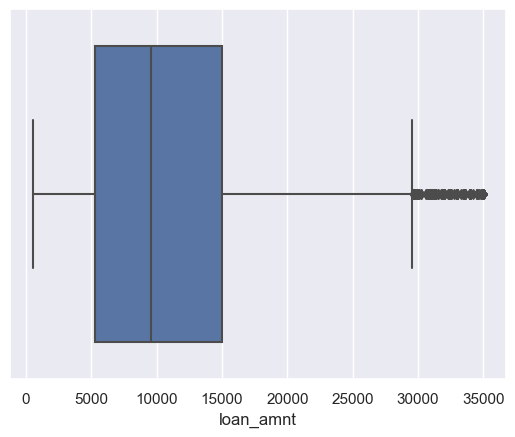

In [176]:
# Plotting Spread of Loan Amount
sns.boxplot(x=loan_df.loan_amnt)

<Axes: xlabel='annual_inc'>

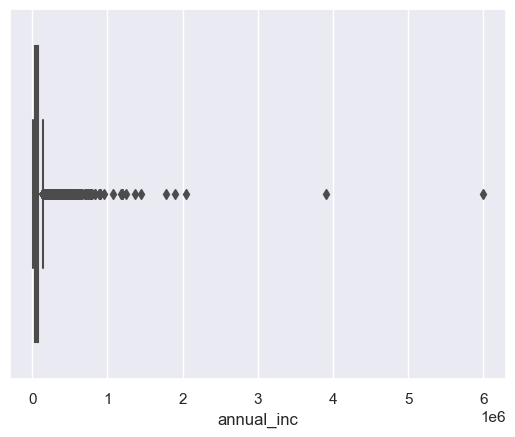

In [177]:
# Plotting Spread of Annual Income
sns.boxplot(x=loan_df.annual_inc)

<Axes: xlabel='dti'>

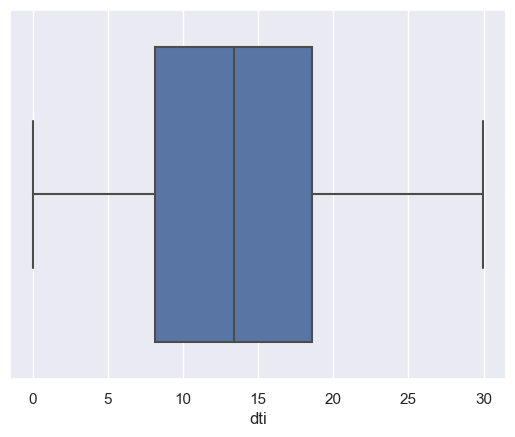

In [178]:
# Plotting Spread of Debt to Income Ratio
sns.boxplot(x=loan_df.dti)

<font color="blue">Removing Outlier for column Annual Income with 99 percentile as there are some outliers beyond this range</font>

In [179]:
loan_df = loan_df[loan_df.annual_inc <= np.percentile(loan_df.annual_inc,99)]

**Conclusion:  <font color="blue">Data is now cleaned for Analysis and below is the size for the cleaned dataset</font>**

In [180]:
# Information about Loan Data Set
get_dataset_info(name_of_dataset="Loan Dataset", df=loan_df, show_details=False)


 Loan Dataset Information: 
-------------------------
Columns: 36 
Rows: 38191


## 2. Univariate Analysis
<span style='background:Gainsboro'>Univariate Analysis  deals with analysing variables one at a time</span><br>
<span style='background:Gainsboro'>Univariate analysis is classified into two types:</span>
- <span style='background:Gainsboro'>**Categorial Univariate Analysis**</span>
  - <span style='background:Gainsboro'>**Unordered Categorial Univariate Analysis**</span>
  - <span style='background:Gainsboro'>**Ordered Categorial Univariate Analysis**</span>
- <span style='background:Gainsboro'>**Quantitative Univariate Analysis**</span>

## Unordered Categorial Univariate Analysis
Analysis is done using single variable and its count. The variable involved does not have and sort of ordering

Text(0, 0.5, 'Count')

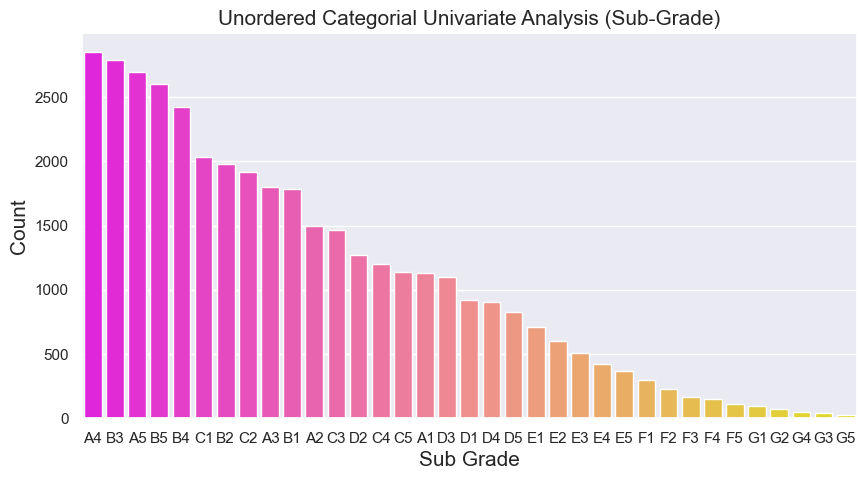

In [181]:
# Plot Countplot graph for sub_grade column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='sub_grade', data=loan_df, order=loan_df.sub_grade.value_counts(ascending=False).index, palette='spring')
plt.title("Unordered Categorial Univariate Analysis (Sub-Grade)", fontsize=15)
plt.xlabel("Sub Grade", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">The Loan procuring frequency is falling for borrowers having Sub-Grade from `E1` and above</font>**

Text(0, 0.5, 'Count')

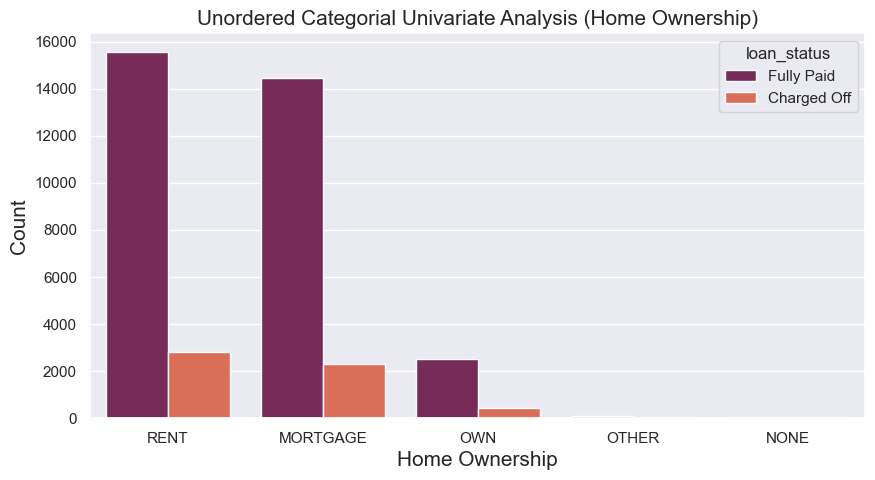

In [182]:
# Plot Countplot graph for home_ownership column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='home_ownership', data=loan_df, hue=loan_df.loan_status, order=loan_df.home_ownership.value_counts(ascending=False).index, palette='rocket')
plt.title("Unordered Categorial Univariate Analysis (Home Ownership)", fontsize=15)
plt.xlabel("Home Ownership", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Maximum amont of Loans are taken by borrowers who live in `Rented` or `Mortgage` House and majority defaulters lie under same category </font>**

Text(0, 0.5, 'Count')

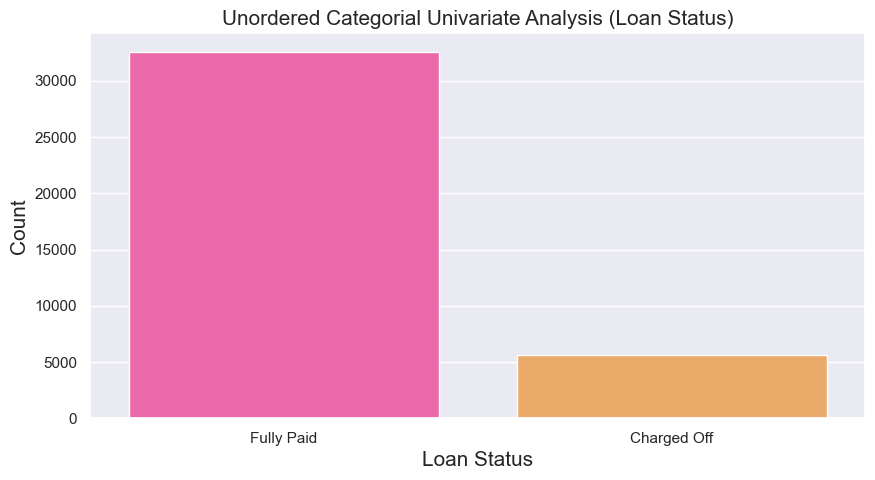

In [183]:
# Plot Countplot graph for loan_status column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='loan_status', data=loan_df, order=loan_df.loan_status.value_counts(ascending=False).index, palette='spring')
plt.title("Unordered Categorial Univariate Analysis (Loan Status)", fontsize=15)
plt.xlabel("Loan Status", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Almost `13%` borrowers have defaulted</font>**

## Ordered Categorial Univariate Analysis
Analysis is done using single variable and its count. The variable involved does have some ordering based on date or numerical values

Text(0, 0.5, 'Count')

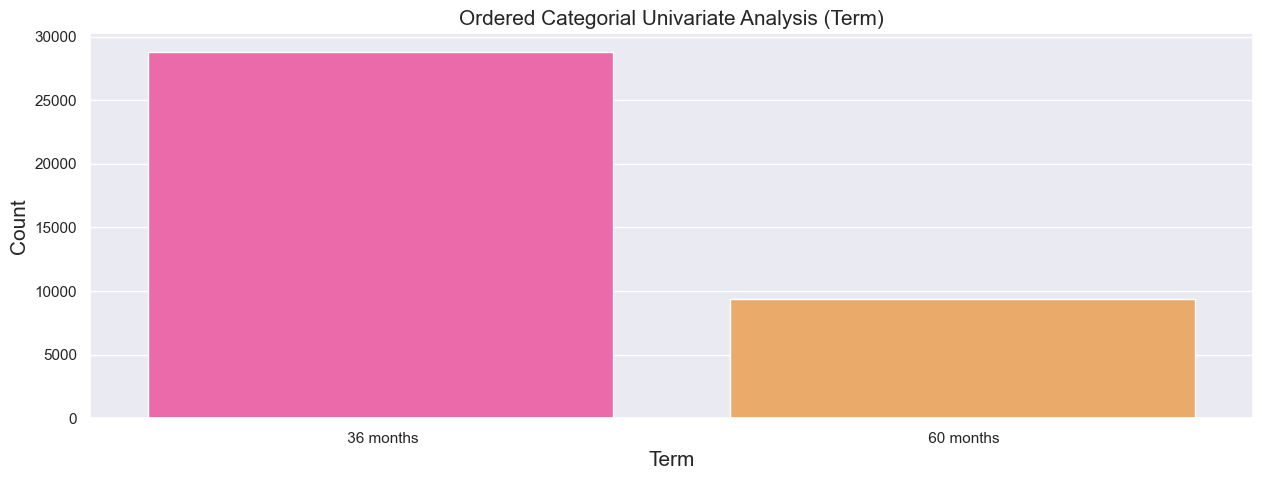

In [184]:
# Plot Countplot graph for term column to find Univariate Analysis
plt.figure(figsize=(15,5))
sns.countplot(x='term', data=loan_df, palette='spring')
plt.title("Ordered Categorial Univariate Analysis (Term)", fontsize=15)
plt.xlabel("Term", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">`75%` Loans are borrowed for less duration i.e. `36 Months` than `60 Months` </font>**

Text(0, 0.5, 'Count')

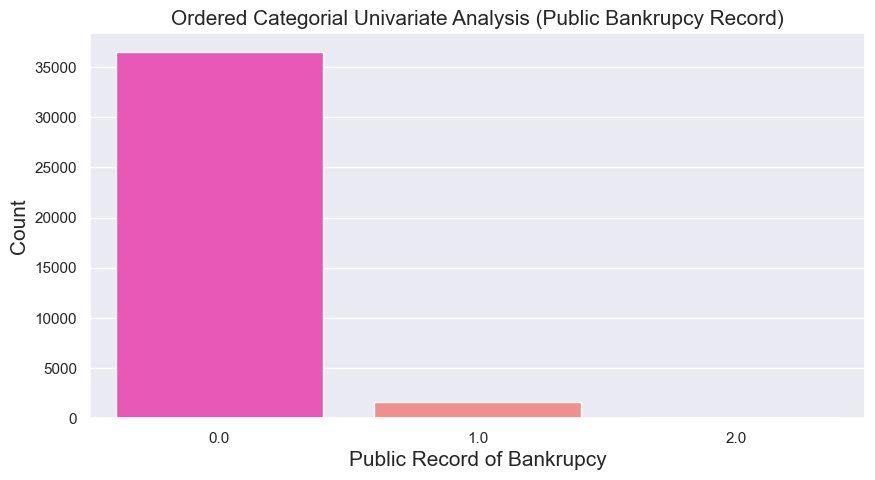

In [185]:
# Plot Countplot graph for pub_rec_bankruptcies column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='pub_rec_bankruptcies', data=loan_df, palette='spring')
plt.title("Ordered Categorial Univariate Analysis (Public Bankrupcy Record)", fontsize=15)
plt.xlabel("Public Record of Bankrupcy", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Very small percentage of borrowers have Public Record Bankrupcies so loan default chances are less if there is no public record bankrupcies for an applicant</font>**

Text(0, 0.5, 'Count')

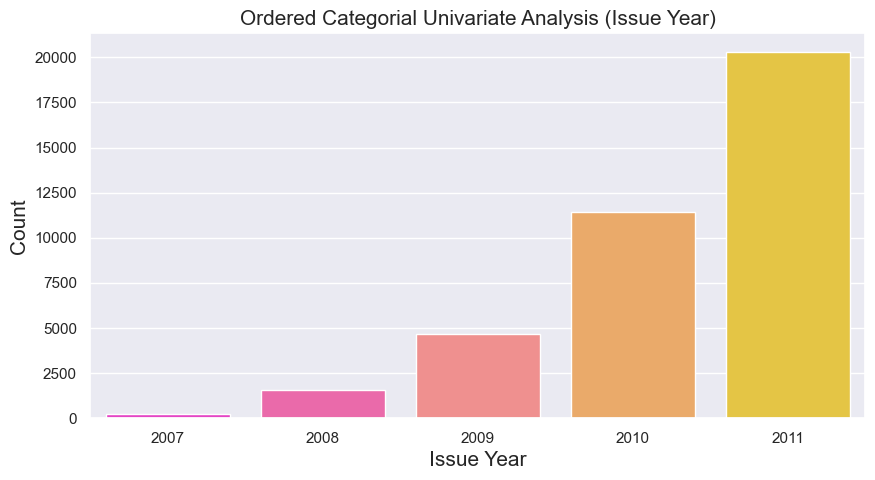

In [186]:
# Plot Countplot graph for issue_year column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='issue_year', data=loan_df, palette='spring')
plt.title("Ordered Categorial Univariate Analysis (Issue Year)", fontsize=15)
plt.xlabel("Issue Year", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Rate of issuing loans increases with time exponentially. Loans borrowed in year 2011 is almost 7 times then year 2008</font>**

Text(0, 0.5, 'Count')

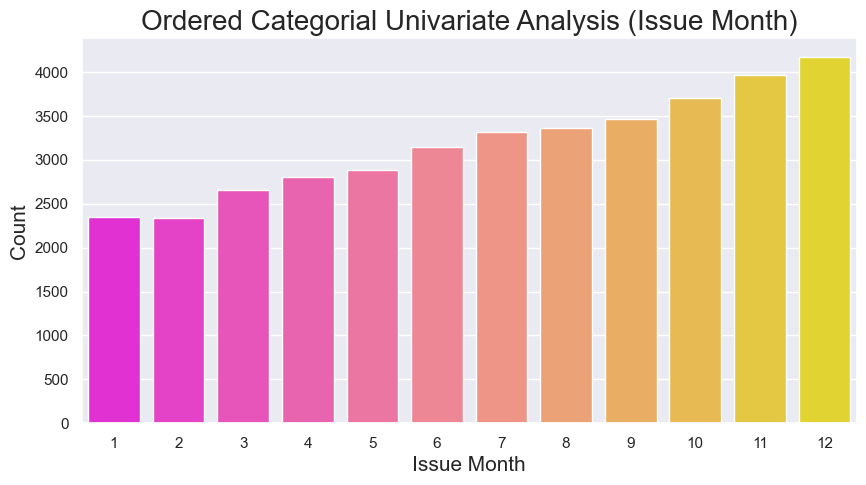

In [187]:
# Plot Countplot graph for issue_month column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='issue_month', data=loan_df, palette='spring')
plt.title("Ordered Categorial Univariate Analysis (Issue Month)", fontsize=20)
plt.xlabel("Issue Month", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">The Volume of Loan borrowing increases at last quarter of the year which indicates borrowers tend to settle there debt consolidations by year end</font>**

## Quantitative Univariate Analysis

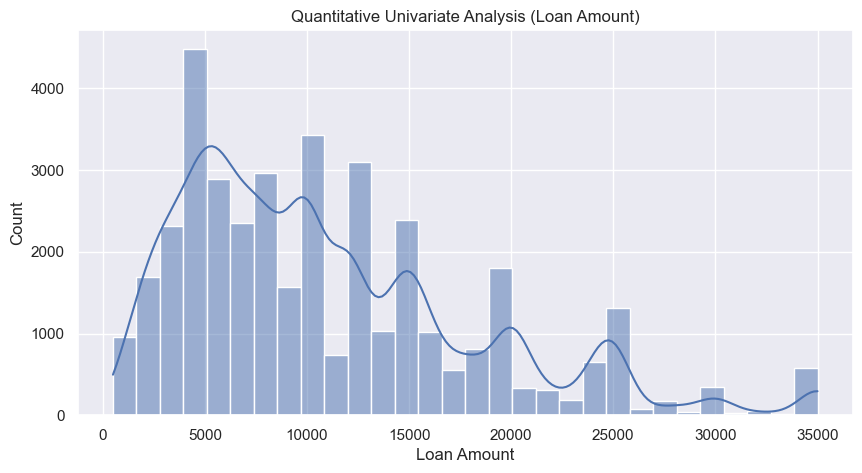

In [188]:
# Histogram (Rank Frequency) plot for distribution of loan_amount
plt.figure(figsize=(10,5))
sns.histplot(loan_df.loan_amnt, kde=True, bins=30)
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Quantitative Univariate Analysis (Loan Amount)', fontsize=12)
plt.show()

**Inference: <font color="blue">Maximum loans are borrowed for amount between 5000 to 15000 </font>**

Text(0, 0.5, 'Count')

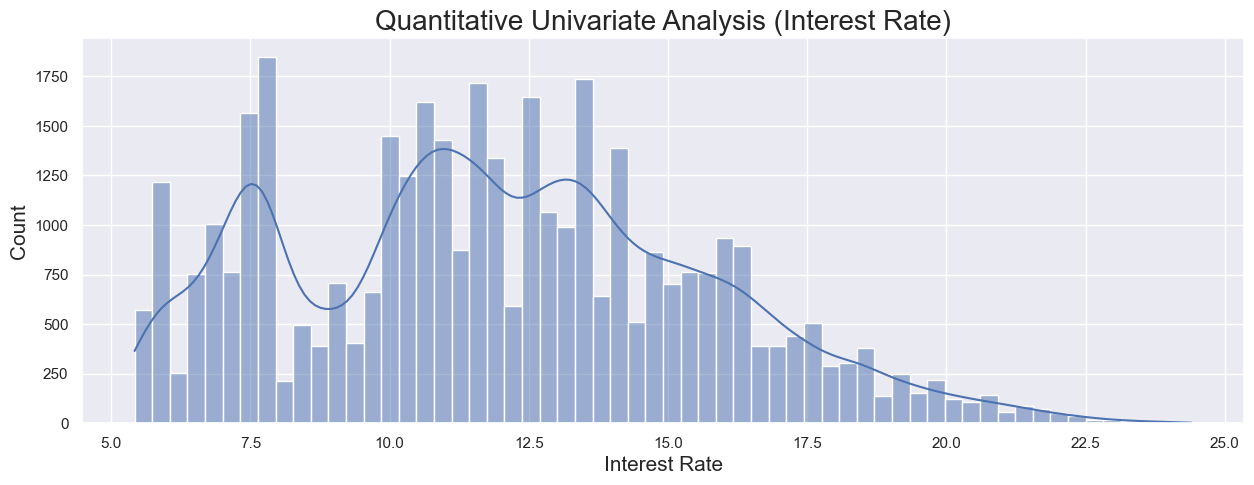

In [189]:
# Histogram (Rank Frequency) Plot for interest_rate column to find Univariate Analysis
plt.figure(figsize=(15,5))
sns.histplot(sorted(loan_df.int_rate), kde=True)
plt.title("Quantitative Univariate Analysis (Interest Rate)", fontsize=20)
plt.xlabel("Interest Rate", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**: 
- **<font color="blue">More Loans are borrowed by interest rates around 5-8% and 10-15%. The quantity of loans borrowed decreases after 15% interest rate.</font>**
- **<font color="blue">No loan is borrowed below 6% and more than 23% interest rate</font>**

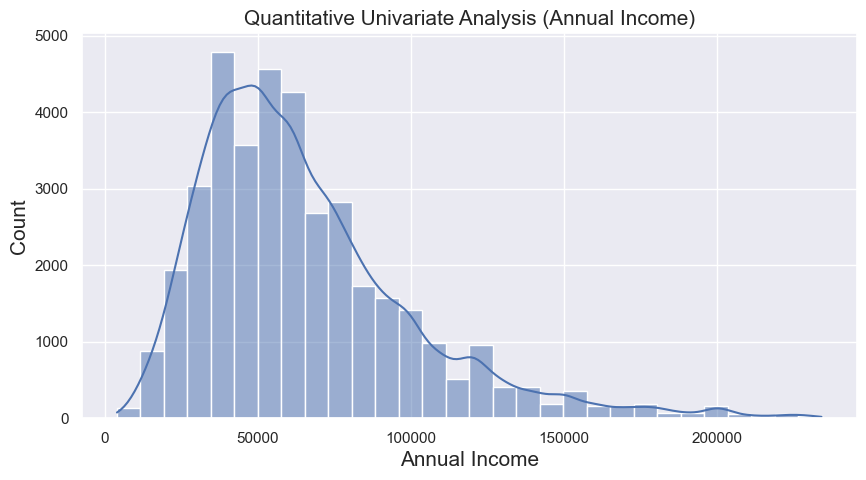

In [190]:
# Histogram (Rank Frequency) plot for distribution of annual_inc
plt.figure(figsize=(10,5))
sns.histplot(loan_df.annual_inc, kde=True, bins=30)
plt.title('Quantitative Univariate Analysis (Annual Income)', fontsize=15)
plt.xlabel('Annual Income', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference: <font color="blue">Majority loans borrowers have less Annual Income as the histogram show left skewed normal distribution</font>**

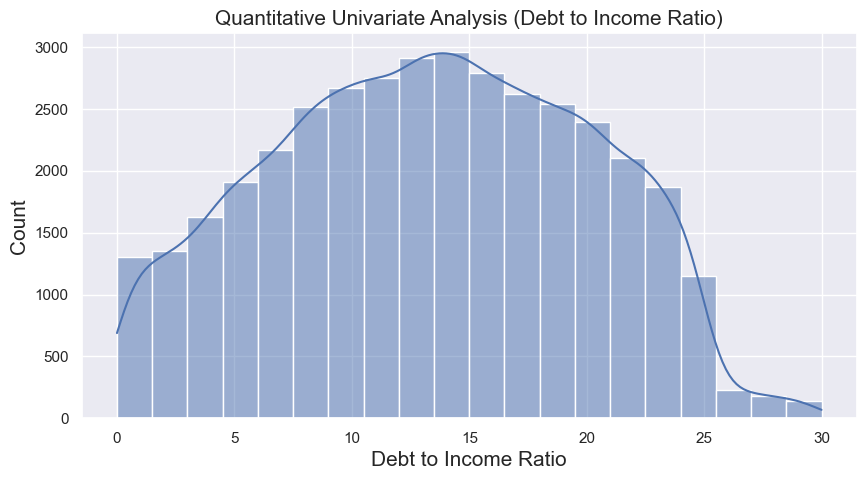

In [191]:
# Histogram (Rank Frequency) plot for distribution of dti
plt.figure(figsize=(10,5))
sns.histplot(loan_df.dti, kde=True, bins=20)
plt.title('Quantitative Univariate Analysis (Debt to Income Ratio)', fontsize=15)
plt.xlabel('Debt to Income Ratio', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference: <font color="blue">Debt to Income ratio is concentrated more between range `10` to `20` of `dti`</font>**

## 3. Segmented Univariate Analysis
Analysis is done grouping data on dimensions, comparision of averages and comparision of other metrics

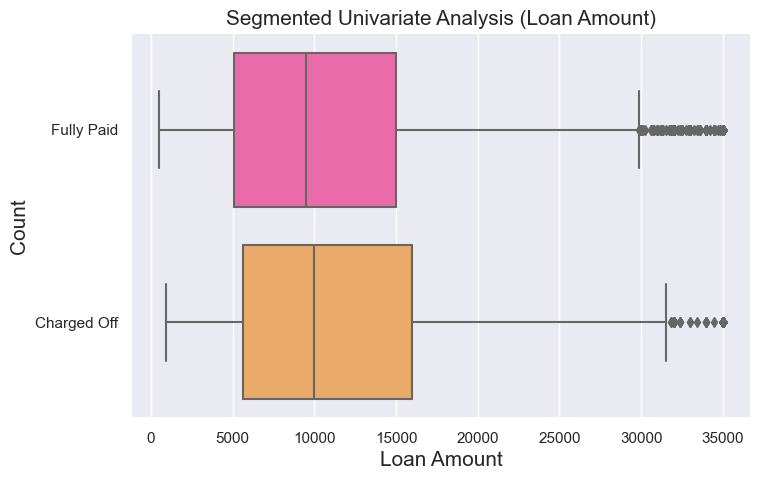

In [192]:
# Box plot for distribution of Loan amount group
plt.figure(figsize=(8,5))
sns.boxplot(data=loan_df, x=loan_df.loan_amnt, y=loan_df.loan_status, palette='spring')
plt.title('Segmented Univariate Analysis (Loan Amount)', fontsize=15)
plt.xlabel('Loan Amount', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference: <font color="blue">Loan defaults increases with the increase in loan amount as 3rd quartile for defaults is higher than paid-off borrowers</font>**

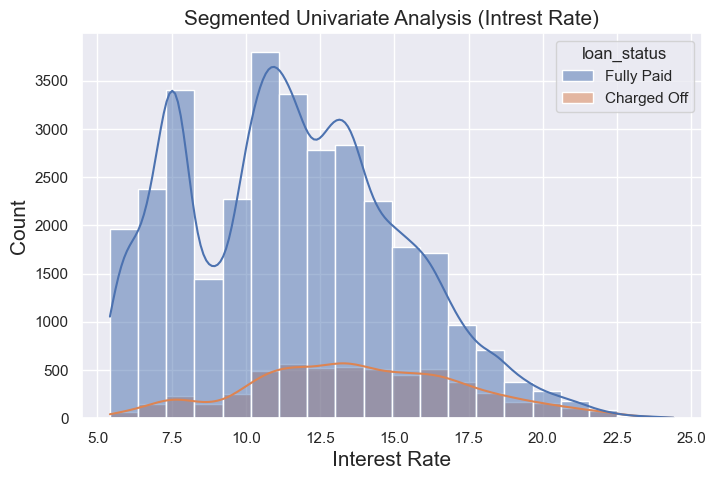

In [193]:
# Histogram plot for distribution of Interest rates
plt.figure(figsize=(8,5))
sns.histplot(data=loan_df, x=loan_df.int_rate, hue=loan_df.loan_status, kde=True, bins=20)
plt.title('Segmented Univariate Analysis (Intrest Rate)', fontsize=15)
plt.xlabel('Interest Rate', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference: <font color="blue">Loan defaults increases with the increase in interest rate </font>**

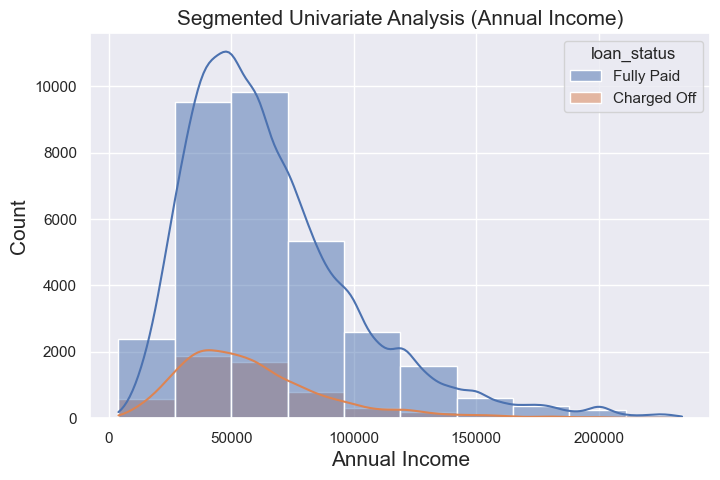

In [194]:
# Histogram plot for distribution of anual income group
plt.figure(figsize=(8,5))
sns.histplot(data=loan_df, x=loan_df.annual_inc, hue=loan_df.loan_status, kde=True, bins=10)
plt.title('Segmented Univariate Analysis (Annual Income)', fontsize=15)
plt.xlabel('Annual Income', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference: <font color="blue">Loan defaults decreases with the increase in annual income. Annual Income is inversely proportional to Loan Defaults </font>**

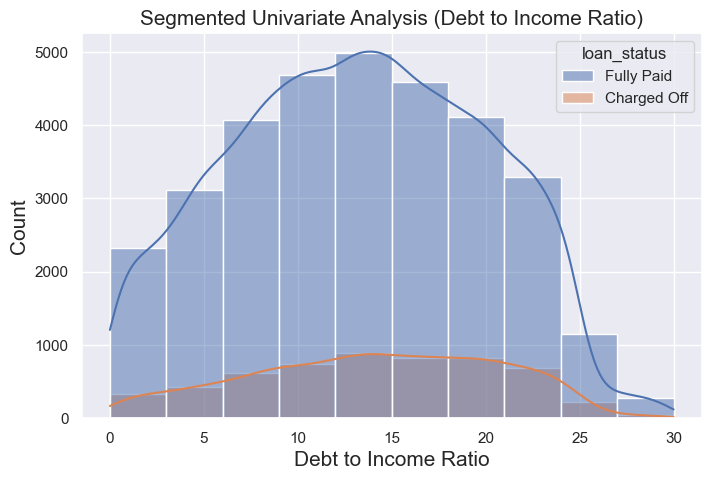

In [195]:
# Histogram plot for distribution of annual_inc group
plt.figure(figsize=(8,5))
sns.histplot(data=loan_df, x=loan_df.dti, hue=loan_df.loan_status, kde=True, bins=10)
plt.title('Segmented Univariate Analysis (Debt to Income Ratio)', fontsize=15)
plt.xlabel('Debt to Income Ratio', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

**Inference: <font color="blue">Loan defaults are highest with Debt to Income Ratio between `10` to `20` </font>**

Text(0, 0.5, 'Count')

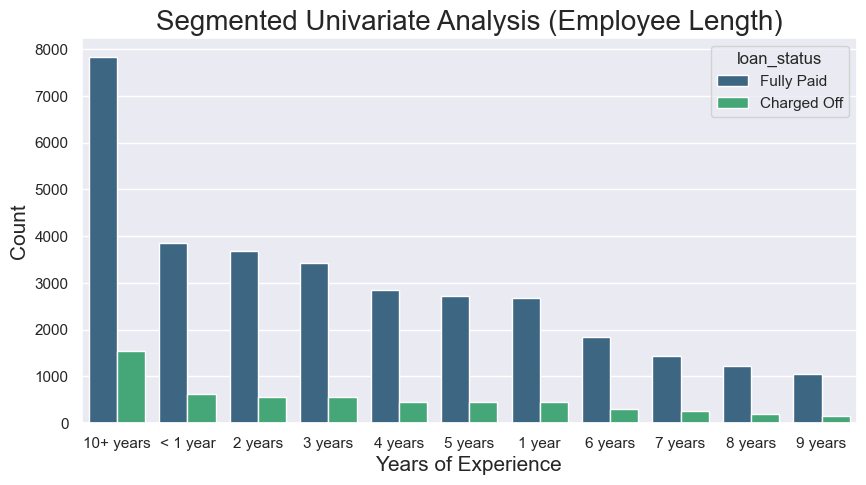

In [196]:
# Plot Countplot graph for employee length column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='emp_length', data=loan_df, hue=loan_df.loan_status, order = loan_df.emp_length.value_counts().index, palette='viridis')
plt.title("Segmented Univariate Analysis (Employee Length)", fontsize=20)
plt.xlabel("Years of Experience", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Maximum borrowers are having higher experience i.e. greater than 10 years and maximum defaulters are for the same experience range</font>**

Text(0, 0.5, 'Count')

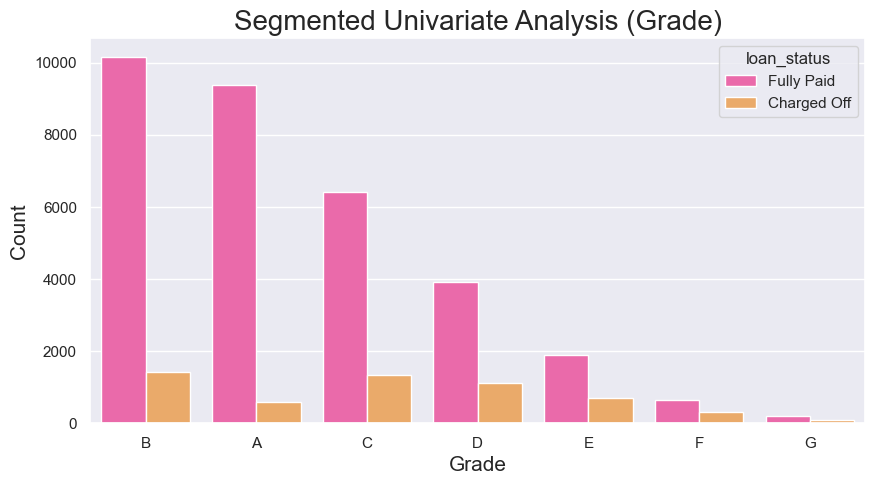

In [197]:
# Plot Countplot graph for grade column to find Univariate Analysis
plt.figure(figsize = (10,5))
sns.countplot(x='grade', data=loan_df, palette='spring', order=loan_df.grade.value_counts().index, hue=loan_df.loan_status)
plt.title("Segmented Univariate Analysis (Grade)", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference**:
- **<font color="blue">High number of loans are taken by borrowers with grade `B` and `A`& Less number of loans are taken by borrowers with grade `G` and `F`</font>**
- **<font color="blue">High percentage of defaulters are from grade `B`, `C` and `D`. So person from grade `G` or `A` is healthy grade or borrowers to lend </font>**

Text(0, 0.5, 'Count')

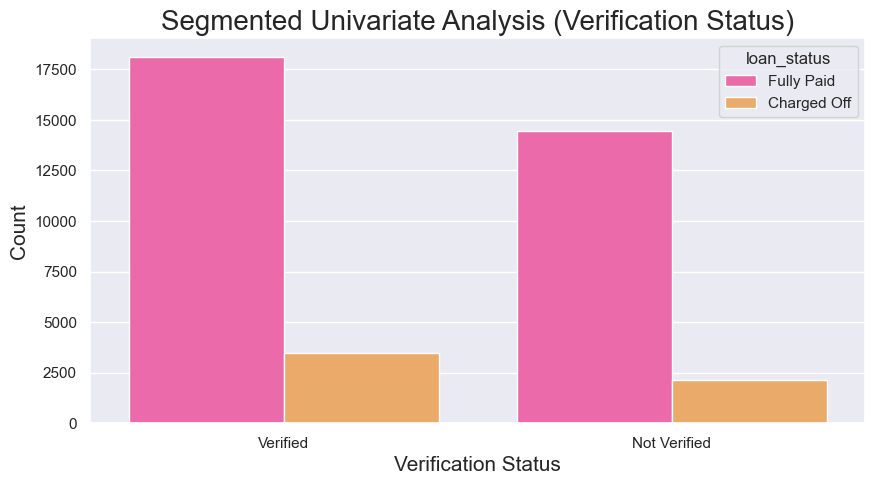

In [198]:
# Plot Countplot graph for verification_status column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='verification_status', data=loan_df, order=loan_df.verification_status.value_counts(ascending=False).index, hue=loan_df.loan_status, palette='spring')
plt.title("Segmented Univariate Analysis (Verification Status)", fontsize=20)
plt.xlabel("Verification Status", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">More than `50%` borrowers are verified by the companies. But surprisingly more defaulters are verified borrowers this shows loop holes in verification process</font>**

Text(52.10910156249999, 0.5, 'Percentage')

<Figure size 1000x500 with 0 Axes>

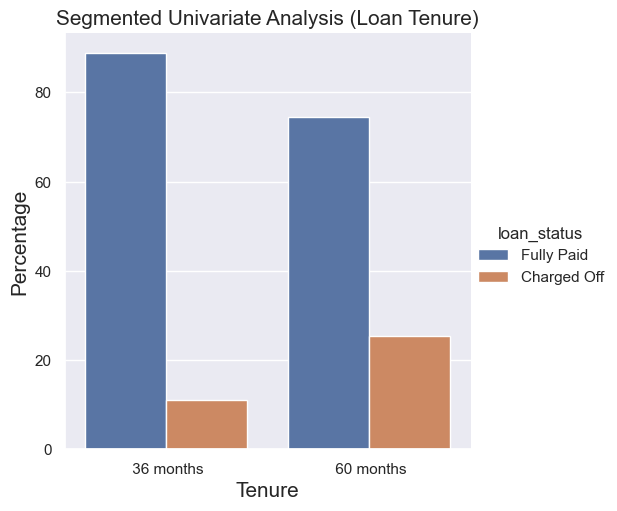

In [199]:
# Plot Catplot graph for term column to find Univariate Analysis
plt.figure(figsize=(10,5))
x,y = 'term', 'loan_status'
term_df = loan_df.groupby(x)[y].value_counts(normalize=True).mul(100)
term_df = term_df.rename('percent').reset_index()
sns.catplot(x=x, y='percent', hue=y, kind='bar', data=term_df)
plt.title("Segmented Univariate Analysis (Loan Tenure)", fontsize=15)
plt.xlabel("Tenure", fontsize=15)
plt.ylabel("Percentage", fontsize=15)

**Inference: <font color="blue">Defaults percentage is `high` for tenure of `60 months` than tenure of `36 months`. So to lend loan for less duration is recommended</font>**

Text(0.5, 0, 'Count')

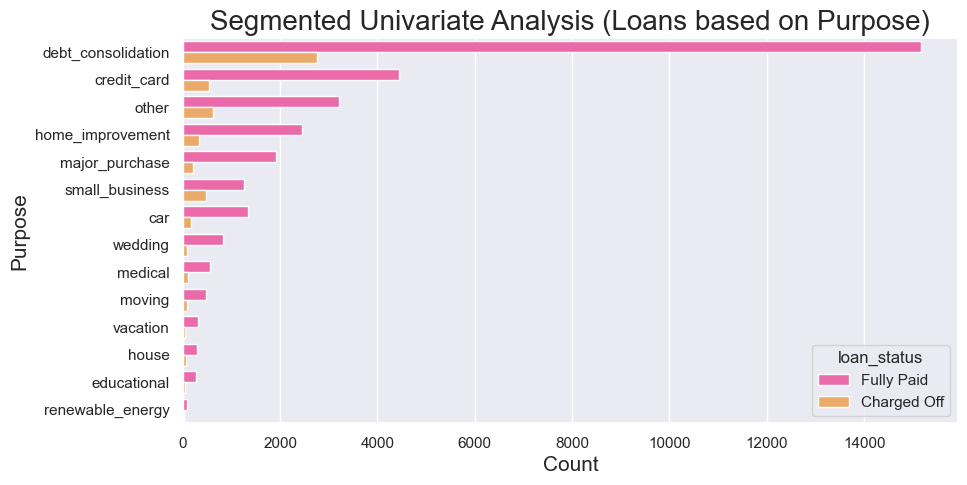

In [200]:
# Plot Countplot graph for purpose column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(y='purpose', data=loan_df, hue=loan_df.loan_status, order=loan_df.purpose.value_counts().index, palette='spring')
plt.title("Segmented Univariate Analysis (Loans based on Purpose)", fontsize=20)
plt.ylabel("Purpose", fontsize=15)
plt.xlabel("Count", fontsize=15)

**Inference: <font color="blue">Maximum loans are borrowed for the purpose of Debt Consolidation of multiple loans and defaults are also more who are lending same purpose</font>**

Text(0, 0.5, 'Count')

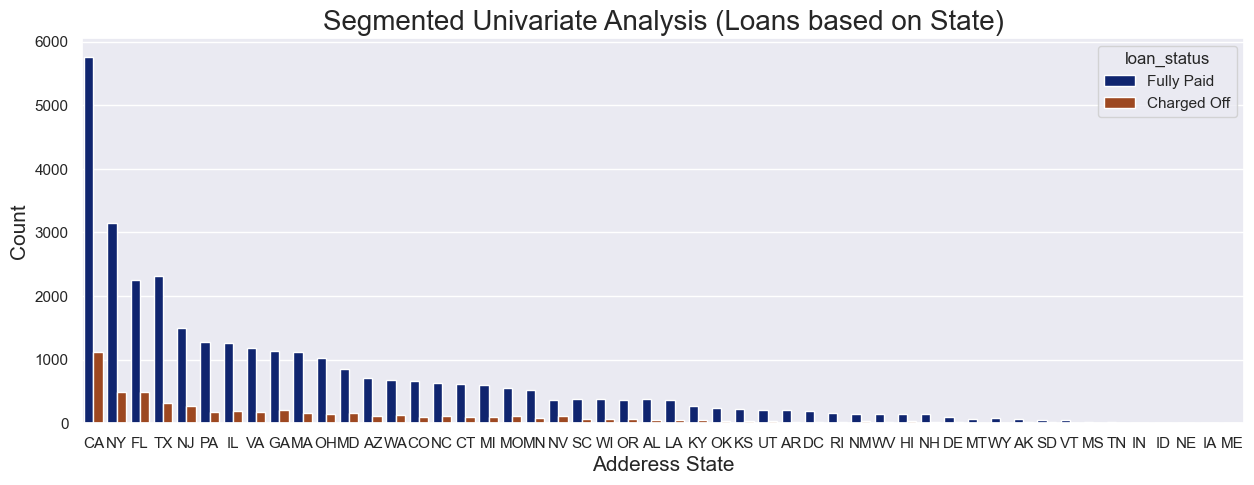

In [201]:
# Plot Countplot graph for addr_state column to find Univariate Analysis
plt.figure(figsize=(15,5))
sns.countplot(x='addr_state', data=loan_df, hue=loan_df.loan_status, order=loan_df.addr_state.value_counts().index, palette='dark')
plt.title("Segmented Univariate Analysis (Loans based on State)", fontsize=20)
plt.xlabel("Adderess State", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Maximum borrowers are from state `California`, `NewYork`, `Texas` and `Florida` and defaulters count is also proportionate</font>**

Text(0, 0.5, 'Count')

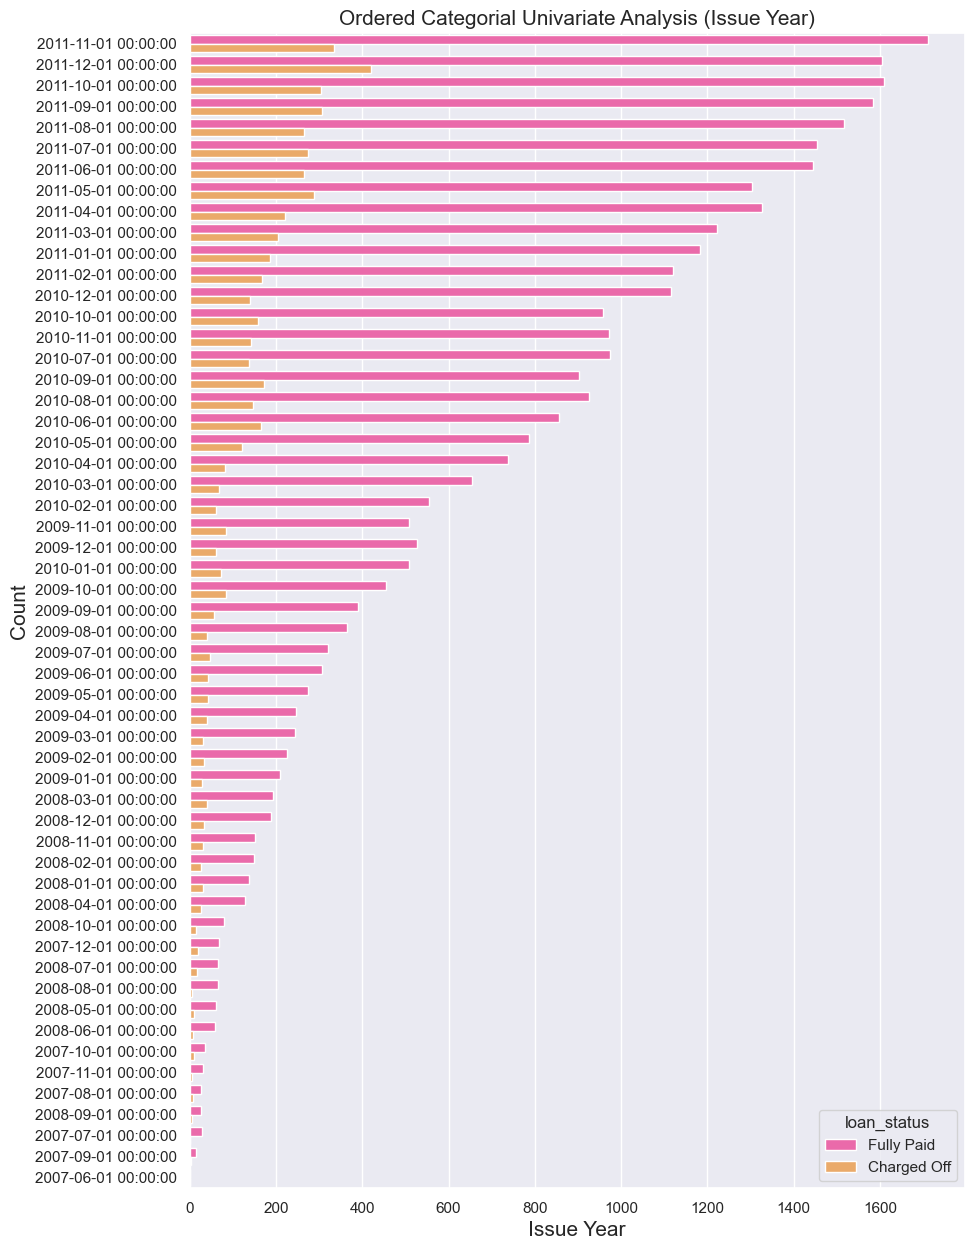

In [202]:
# Plot Countplot graph for issue_year column to find Univariate Analysis
plt.figure(figsize=(10,15))
sns.countplot(y='issue_date', data=loan_df, hue=loan_df.loan_status, order=loan_df.issue_date.value_counts().index, palette='spring')
plt.title("Ordered Categorial Univariate Analysis (Issue Year)", fontsize=15)
plt.xlabel("Issue Year", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">Loan Defaults are increasing from 2009 to 2011 most probably due to recession</font>**

Text(0, 0.5, 'Count')

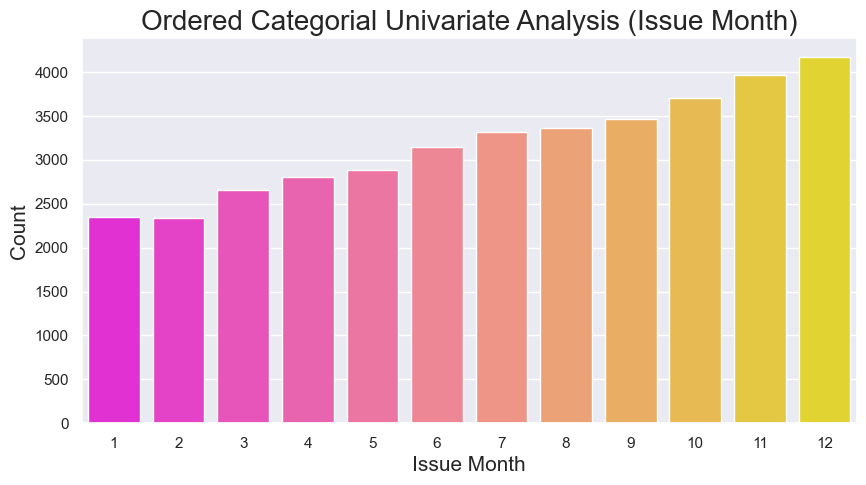

In [203]:
# Plot Countplot graph for issue_month column to find Univariate Analysis
plt.figure(figsize=(10,5))
sns.countplot(x='issue_month', data=loan_df, palette='spring')
plt.title("Ordered Categorial Univariate Analysis (Issue Month)", fontsize=20)
plt.xlabel("Issue Month", fontsize=15)
plt.ylabel("Count", fontsize=15)

**Inference: <font color="blue">The Volume of loan borrowing increases at last quarter of the year which indicates borrowers tend to settle there debt consolidations by year end</font>**

## 4. Bivariate Analysis
Analysis between 2 vairables is called Bivariate Analysis
- **Bivariate Analysis on Continuous Variables**
- **Bivariate Analysis on Categorial Variables**

### Bivariate Analysis on Continuous Variables

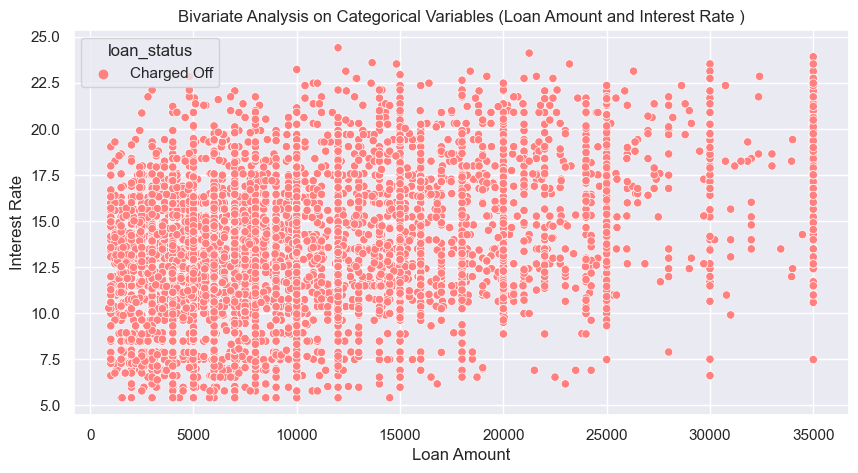

In [204]:
# Relation between of Loan Amount and Interest rate
plt.figure(figsize=(10,5))
sns.scatterplot(data=loan_df[(loan_df.loan_status == "Charged Off")], x='loan_amnt', y='int_rate', hue='loan_status', palette='spring')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.title('Bivariate Analysis on Categorical Variables (Loan Amount and Interest Rate )',fontsize=12)
plt.show()

**Inference: <font color="blue">Loan Defaults increase with increase in Loan Amount or Interest Rate between `10%` to `17.5%`</font>**

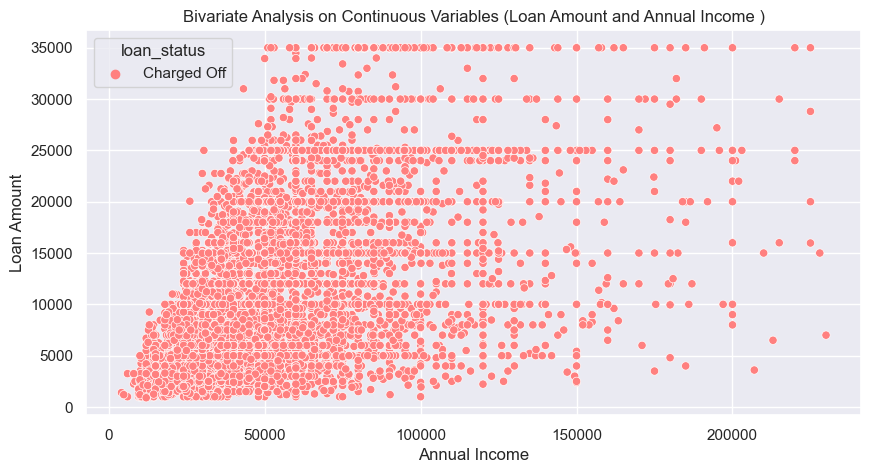

In [205]:
# Relation between of Annual Income and Loan Amount
plt.figure(figsize=(10,5))
sns.scatterplot(data=loan_df[(loan_df.loan_status == "Charged Off")], x='annual_inc', y='loan_amnt', hue='loan_status', palette='spring')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('Bivariate Analysis on Continuous Variables (Loan Amount and Annual Income )',fontsize=12)
plt.show()

**Inference: <font color="blue">Dense loan defaults is visible with `High Loan Amount` and `Low Annual Income`</font>**

### Bivariate Analysis on Continuous and Categorial Variables

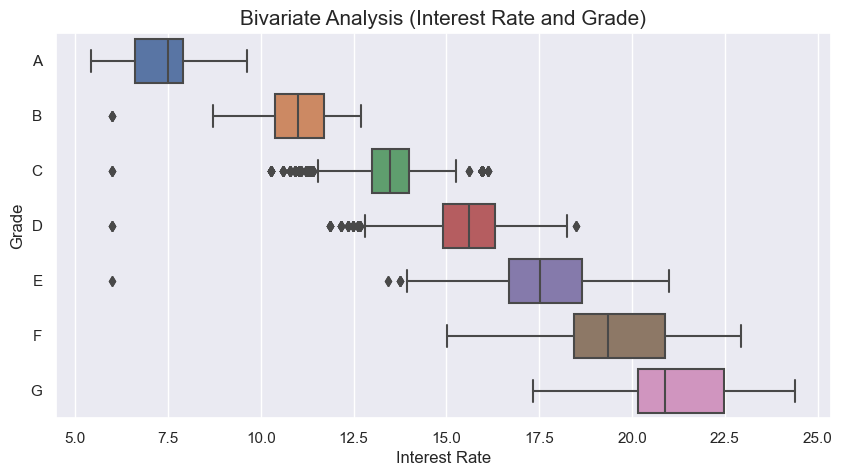

In [206]:
# Relationship between Interest rate and grade
plt.figure(figsize=(10,5))
sns.boxplot(data=loan_df,x='int_rate',y='grade')
plt.xlabel('Interest Rate')
plt.ylabel('Grade')
plt.title('Bivariate Analysis (Interest Rate and Grade)',fontsize=15)
plt.show()

**Inference: <font color="blue">Higher Interest Rate are assigned to borrowers with Higher Grade from `A - G` </font>**

### Bivariate Analysis on Categorial Variables

In [207]:
# Creating Segment for Bivariate Analysis
loan_inc_groups_df = loan_df[['pub_rec_bankruptcies']].copy()
loan_inc_groups_df['annual_inc_groups'] = pd.cut(loan_df.annual_inc, bins=5, precision=0, labels=['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])

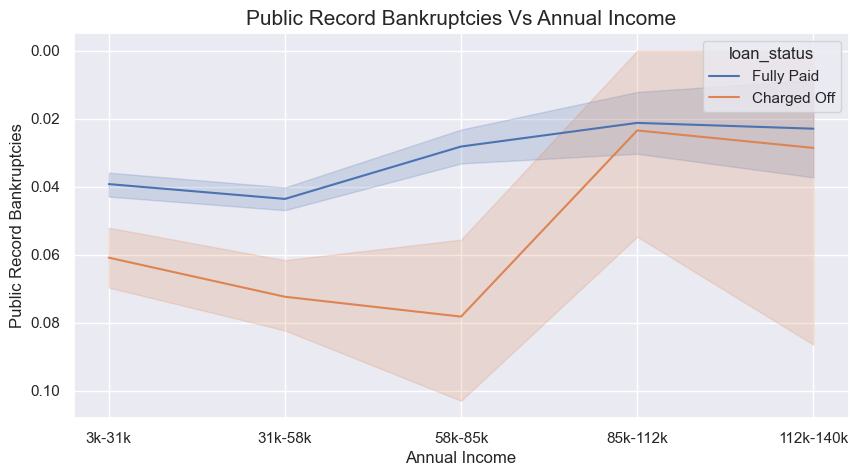

In [208]:
# Relationship between Annual income and Public Record Banckrupcy
plt.figure(figsize=(10,5))
sns.lineplot(x=loan_inc_groups_df.annual_inc_groups, y=loan_inc_groups_df.pub_rec_bankruptcies.astype('category'), hue=loan_df.loan_status)
plt.xlabel('Annual Income')
plt.ylabel('Public Record Bankruptcies')
plt.title('Public Record Bankruptcies Vs Annual Income',fontsize=15)
plt.show()

**Inference: <font color="blue">Borrowers having no public record bankrupcy usually are not defaulters </font>**

<Figure size 1000x500 with 0 Axes>

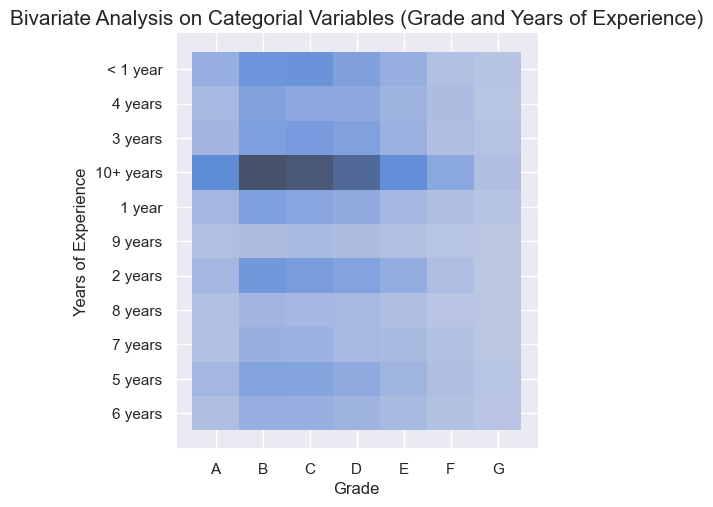

In [209]:
# Relationship between Grade and Years of Experience
plt.figure(figsize=(10,5))
sns.displot(data=loan_df[(loan_df.loan_status == "Charged Off")], x="grade", y='emp_length')
plt.xlabel('Grade')
plt.ylabel('Years of Experience')
plt.title('Bivariate Analysis on Categorial Variables (Grade and Years of Experience)',fontsize=15)
plt.show()

**Inference: <font color="blue">Higher Interest Rate are assigned to borrowers with Higher Grade from `A - G` </font>**

## 5. Derived Metrics
Create variables using correlationship between variables

In [210]:
# Deriving the columns for generating correlation
loan_df_for_corr = loan_df[['loan_status', 'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'verification_status', 'pub_rec_bankruptcies', 'issue_month', 'issue_year']].copy()
loan_df_for_corr['term'] = loan_df.term.apply(lambda x: str(x).replace("months", "")).astype('float')
loan_df_for_corr['loan_status'] = loan_df.loan_status.apply(lambda x: 1 if str(x) == "Charged Off" else 0 ).astype('float')
loan_df_for_corr['verification_status'] = loan_df.verification_status.apply(lambda x: 0 if str(x) == "Verified" else 1 ).astype('float')

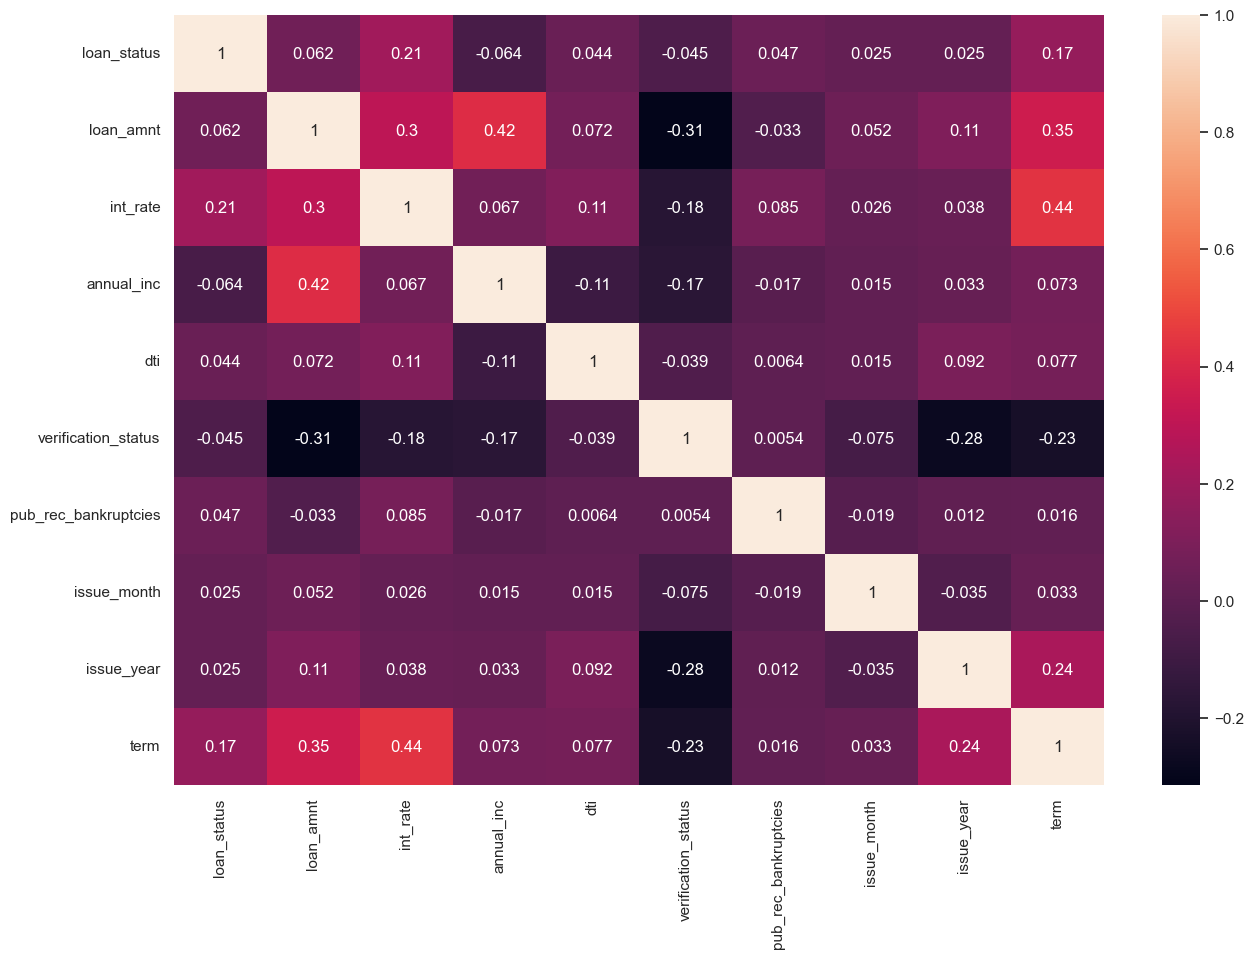

In [211]:
# Creating map of Correlation between different variables
plt.figure(figsize=(15,10))
sns.heatmap(data=loan_df_for_corr.corr(), annot=True)
plt.show()

**Inference**: 
- **<font color="blue">Loan Status is directly proporional to Loan Amount by 0.062, hihger the loan amount higher the chances of default</font>**    
- **<font color="blue">Loan Status is directly proportional to Interest rate by 0.21, hihger the interest higher the chances of default</font>**
- **<font color="blue">Loan Status is inversely proportional to Annual Income by 0.064, hihger the annual income less the chances of default</font>**
- **<font color="blue">Loan Status is directly proporional to Debt to Income ratio by 0.044, hihger the dti higher the chances of default</font>**  
- **<font color="blue">Loan Status is inversely proporional to Verification Status by 0.045, more chances of default if verification is successfull which shows flaws in Verification status</font>**      
- **<font color="blue">Loan Status is directly proporional to Pub Rec Banckrupcy ratio by 0.047, hihger the Public Record for Banckrupcy higher the chances of default</font>**
- **<font color="blue">Loan Status is directly proporional to Issuing months by 0.025, More chances of default at the last qurter</font>**
- **<font color="blue">Loan Status is directly proporional to Issuing year by 0.025, More chances of default at as we proceed with timeline</font>**
- **<font color="blue">Loan Status is directly proporional to Loan Tenure by 0.047, hihger the tenure higher the chances of default</font>**

In [213]:
# grade
# sub-grade
# home_ownership
# loan_status
# pub_record_bankrupties
# issue_date
# issue_month - d
# issue_year - d
# loan_amount
# interest_rate
# annual_income
# dti
# verification status
# term or loan tenure
# purpose
# address state

## Detailed Analysis
#### Data Cleaning
#### Univariate Analysis
- The Loan procuring frequency is falling for borrowers having Sub-Grade from E1 and above
- Maximum amont of Loans are taken by borrowers who live in Rented or Mortgage House and majority defaulters lie under same category
- Almost 13% borrowers have defaulted
- Lesser the duration less the chances of default, 75% Loans are borrowed for less duration i.e. 36 Months than 60 Months
- Very small percentage of borrowers have Public Record Bankrupcies so loan default chances are less if there is no public record bankrupcies for an applicant.
- Rate of issuing loans increases with time exponentially. Loans borrowed in year 2011 is almost 7 times then year 2008
- The Volume of Loan borrowing increases at last quarter of the year which indicates borrowers tend to settle there debt consolidations by year end
- Maximum loans are borrowed for amount between 5000 to 15000
- More Loans are borrowed by interest rates around 5-8% and 10-15%. The quantity of loans borrowed decreases after 15% interest and no loan is borrowed below 6% and more than 23% interest
- Majority loans borrowers have less Annual Income as the histogram show left skewed normal distribution
- Debt to Income ratio is concentrated more between range 10 to 20 of dti
#### Segmented Univariate Analysis
- Loan defaults increases with the increase in loan amount as default has 3rd quartile higher than paid-off.
- Loan defaults increases with the increase in interest rate
- Loan defaults decreases with the increase in annual income. Annual Income is inversely proportional to Loan Defaults
- Loan defaults are highest with Debt to Income Ratio between 10 to 20
- Maximum borrowers are having higher experience i.e. greater than 10 years and maximum defaulters are for the same experience range
- High number of loans are taken by borrowers with grade B and A & Less number of loans are taken by borrowers with grade G and F. High percentage of defaulters are from Grade B, C and D. So person from grade A is healthy grade or borrowers to lend
- More than 50% borrowers are verified by the companies. But surprisingly more defaulters are verified borrowers this show loop holes with verification process.
- Defaults percentage is high for tenure of 60 months than tenure of 36 months. So to lend loan for less duration is recommended
- Maximum loans are borrowed for the purpose of Debt Consolidation of multiple loans and defaults are also more for same purpose
- Maximum borrowers are from state California, NewYork, Texas and Florida and defaulters count is also proportionate
- Loan Defaults are increasing from 2009 to 2011 may be due to recession
- The Volume of Loan borrowing increases at last quarter of the year which indicates borrowers tend to settle there debt consolidations by year end and this results as main purpose for the loan procurement.
#### Quantitative Univariate Analysis
#### Bivariate Analysis
#### Derived Metrics